In [1]:
import importlib

import Environment
import Models
from Environment.custom_env import CustomEnvironment
import json
import torch
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from Models.ActorCritic import ActorCritic
from Models.SoftActorCritic import SoftActorCritic
from Models.DDQN import DoubleDQN

pygame 2.5.2 (SDL 2.28.3, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# importlib.reload(Environment)
# importlib.reload(Models)

In [3]:
torch.cuda.is_available()

True

In [4]:
f = open('Environment/env_config_reg.json')
env_variables = json.load(f)
f.close

<function TextIOWrapper.close()>

In [5]:
env = CustomEnvironment(env_config=env_variables, render_mode="n")
# env = parallel_env(render_mode="human")
# env.reset(seed=42)

0.1


In [6]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler(feature_range=(0, 128))

In [7]:
ac_config = open('Environment/ac_config.json')
ac_variables = json.load(ac_config)
ac_config.close

sac_config = open('Environment/sac_config.json')
sac_variables = json.load(sac_config)
sac_config.close

ddqn_config = open('Environment/ddqn_config.json')
ddqn_variables = json.load(ddqn_config)
ddqn_config.close

<function TextIOWrapper.close()>

In [8]:
# ddqn_1 = DoubleDQN(ddqn_variables)
# ddqn_2 = DoubleDQN(ddqn_variables)
# ddqn_3 = DoubleDQN(ddqn_variables)
ac = ActorCritic(ac_variables)
# sac = SoftActorCritic(sac_variables)

In [9]:
# models = {i:ddqn_1 for i in range(env.n_agents)}
models = {0: ac}

In [10]:
# ddqn_1.policy_net.device

In [11]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for i, p in enumerate(named_parameters):
        
        if(p.requires_grad):
            layers.append(i)
            ave_grads.append(p.grad.cpu().abs().mean())
            max_grads.append(p.grad.cpu().abs().max())

    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    plt.show()

In [12]:
import time

In [13]:
episodes = 100
episodes_returns = {}
episodes_returns[0] = []

episodes_losses = {}
episodes_losses[0] = []
for episode in tqdm(range(episodes)): #episodes loop"

    curr_obs,infos = env.reset() #reset environment after each episode\n",
    # print(curr_obs[0][1])

    losses = []
    while(env.agents): #until there are any surviving agents 

        actions = {}
        log_probs = {}

        for a in env.agents:
            # print(curr_obs[a])
            # curr_time = time.time()
            act, log_prob = models[a].select_action(state = curr_obs[a])
            # print(time.time() - curr_time)
            actions[a] = act
            log_probs[a] = log_prob

        # for i in range(env.n_agents): #objects contains all of the models, get the corresponding actions from each policy\n",
            
        #     if i in env.agents:
        #         act, log_prob = env.agents_objects[i].brain1.select_action(state = torch.tensor(curr_obs[i], dtype = torch.float32))
        #         actions[i] = act
        #         log_probs[i] = log_prob
        #     else:
        #         actions[i] = env.num_actions
        #         log_probs[i] = 69
            
        # print(actions)

        next_obs, rewards, terminations, truncations, infos = env.step(actions)
        # if env.timestep % 100 == 0:
        #     # plot_grad_flow(models[0].policy_net.parameters())
        #     print(rewards)
        

        for id, obs in next_obs.items():
            # print("main shape", obs[0].shape)
            if obs is None:
                print(env.timestep)
                print("next state is None")
            # curr_time = time.time()
            models[id].push_to_buffer(curr_obs[id], actions[id], rewards[id], obs, log_probs[id], terminations[id])
            # print(time.time() - curr_time)

            # curr_time = time.time()            
            loss = models[id].update_weights()
            # print(time.time() - curr_time)
            # print()

            if loss is not None:
                losses.append(loss)
            # if(terminations[id] == True):
            #     # loss = models[id].update_weights()
            #     print(f"Agent {id} died at timestep {env.timestep: 3d}. Current reward {rewards[id]: .3f}.")
            #     losses[id] = loss


        if env.timestep % 100 == 0:
            for id, agent in env.agents_objects.items():
                # plot_grad_flow(models[0].policy_net.parameters())
                print(f"{id}: {agent.reward: .3f}", end=' ')

            print()
        
        # for i in range(env.n_agents):

        #     if i in env.agents:
        #         env.agents_objects[i].brain1.push_to_buffer(torch.tensor(curr_obs[i], dtype = torch.float32),actions[i],rewards[i],torch.tensor(next_obs[i], dtype = torch.float32),log_probs[i],terminations[i])
        #         env.agents_objects[i].brain1.update_weights() 
            
        #     if i in env.justdie:
        #         env.justdie[i].brain1.push_to_buffer(torch.tensor(curr_obs[i], dtype = torch.float32),actions[i],rewards[i],torch.tensor(next_obs[i], dtype = torch.float32),log_probs[i],terminations[i])
        #         loss = env.justdie[i].brain1.update_weights() 
        #         del env.justdie[i]
        #         losses[i] = loss
        
        curr_obs = next_obs

        if env.timestep == env.max_episode_size - 1:
            for agent in env.agents_objects:
                episodes_returns[agent].append(env.agents_objects[agent].reward)
                episodes_losses[agent].append(np.array(losses).mean())
    
    print(f"Episode {episode} end")
    # print(len(ddqn_1.replay_buffer))
    # print(f"Losses {losses}")
    # print(episodes_returns)
    # print(episodes_losses)

    if (episode + 1) % 10 == 0:
        # ddqn
        # ddqn_dict = {}
        # ddqn_dict['policy_net'] = models[0].policy_net.to('cpu').state_dict()
        # ddqn_dict['target_net'] = models[0].target_net.to('cpu').state_dict()
        # # torch.save(models[0].policy_net.state_dict())
        # # torch.save(models[0].target_net.state_dict())
        # torch.save(ddqn_dict, "SavedWeights/DDQN_Weights.pkl")
        # del ddqn_dict
        # models[0].policy_net.to(models[0].device)
        # models[0].target_net.to(models[0].device)

        # ac
        ac_dict = {}
        ac_dict['actor'] = models[0].actor.to('cpu').state_dict()
        ac_dict['critic'] = models[0].critic.to('cpu').state_dict()
        torch.save(ac_dict, "SavedWeights/AC_Weights.pkl")
        del ac_dict
        models[0].actor.to(models[0].device)
        models[0].critic.to(models[0].device)
        # torch.save(models[1].actor.state_dict())
        # torch.save(models[1].critic.state_dict())

        # # sac
        # sac_dict = {}
        # sac_dict['actor_policy_net'] = models[2].actor_policy_net.to('cpu').state_dict()
        # sac_dict['critic_q_net'] = models[2].critic_q_net.to('cpu').state_dict()
        # sac_dict['critic_q_target_net'] = models[2].critic_q_target_net.to('cpu').state_dict()
        # sac_dict['log_alpha'] = models[2].log_alpha.to('cpu')
        # torch.save(sac_dict, "SavedWeights/SAC_Weights.pkl")
        # del sac_dict
        # models[2].actor_policy_net.to(models[2].device)
        # models[2].critic_q_net.to(models[2].device)
        # models[2].critic_q_target_net.to(models[2].device)
        # models[2].log_alpha.to(models[2].device)
        # torch.save(models[1].actor_policy_net.state_dict())
        # torch.save(models[1].critic_q_net.state_dict())
        # torch.save(models[1].critic_q_target_net.state_dict())

    env.close()

  0%|          | 0/100 [00:00<?, ?it/s]

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.005000591278076172
0.1015172004699707
0.011003971099853516
0.0009996891021728516
0.03799796104431152
0.0040013790130615234
0.0009980201721191406
0.038510799407958984
0.0039997100830078125
0.0009996891021728516
0.038001060485839844
0.003998517990112305
0.001004934310913086
0.036510467529296875
0.004000186920166016
0.0009996891021728516
0.03699922561645508
0.003999948501586914
0.0009989738464355469
0.03650546073913574
0.003001689910888672
0.0009999275207519531
0.03699922561645508
0.00400233268737793
0.002002239227294922
0.037523746490478516
0.003991127014160156
0.0009965896606445312
0.03799581527709961
0.0040013790130615234
0.001003265380859375
0.03751111030578613
0.003999948501586914
0.0009996891021728516
0.03799939155578613
0.0040051937

: 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [ ]:
def eps_thresh():
    # print(np.arange(0, 100*490, 490))
    arr = np.stack([np.arange(0, 100*490, 490), 40000 * np.ones(np.arange(0, 100*490, 490).shape[0])])
    arr = np.min(arr, axis=0)
    return 0.05 + (0.95 - 0.05) * np.exp(-1 * arr/40000)

eps_thresh().shape

(100,)

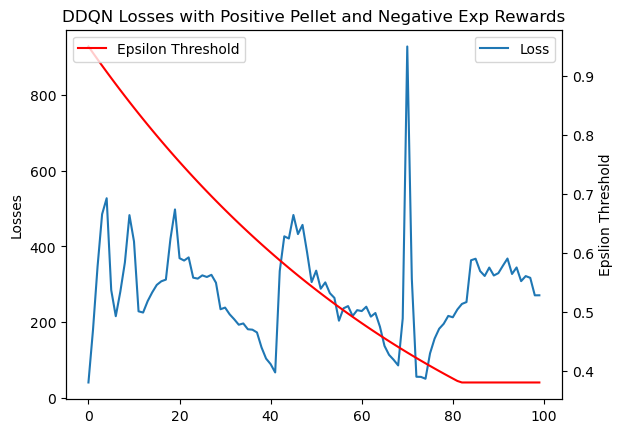

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(x=np.arange(episodes), y=episodes_losses[0], ax=ax, label='Loss')
plt.legend(loc='upper right')
plt.ylabel("Losses")
# sns.regplot(x='round', y='money', data=firm, ax=ax)
ax2 = ax.twinx()
sns.lineplot(x=np.arange(episodes), y=eps_thresh(), ax=ax2, color='r', label='Epsilon Threshold')
# sb.regplot(x='round', y='dead', data=firm, ax=ax2, color='r')
plt.legend(loc='upper left')
plt.xlabel("Episodes")
plt.ylabel("Epslion Threshold")
plt.title("DDQN Losses with Positive Pellet Rewards")
plt.show()

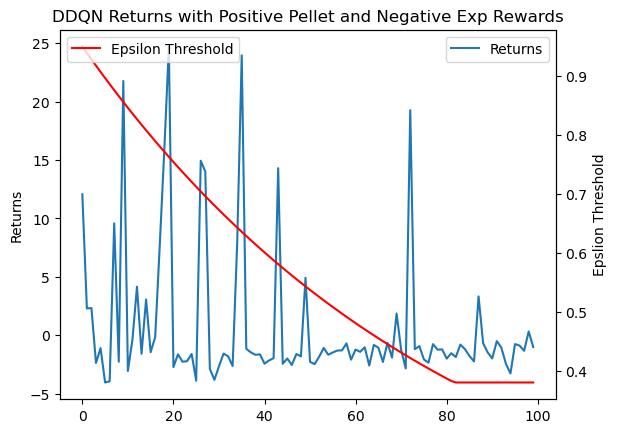

In [ ]:
# sns.lineplot(x=np.arange(episodes), y=episodes_returns[0])
# # plt.xkcd(scale=0)
# # mpl.rcParams.update(mpl.rcParamsDefault)
# # plt.rcdefaults()
# plt.figure(figsize=(50, 100))
# plt.show()
# # plt.savefig(fname='DDQN-GRU-PosPellet.png')

fig, ax = plt.subplots()
sns.lineplot(x=np.arange(episodes), y=episodes_returns[0], ax=ax, label='Returns')
plt.legend(loc='upper right')
plt.ylabel("Returns")
# sns.regplot(x='round', y='money', data=firm, ax=ax)
ax2 = ax.twinx()
sns.lineplot(x=np.arange(episodes), y=eps_thresh(), ax=ax2, color='r', label='Epsilon Threshold')
# sb.regplot(x='round', y='dead', data=firm, ax=ax2, color='r')
plt.legend(loc='upper left')
plt.xlabel("Episodes")
plt.ylabel("Epslion Threshold")
plt.title("DDQN Returns with Positive Pellet Rewards")
plt.show()

In [ ]:
plt.imshow(curr_obs[0][0][1].astype(np.int), cmap='gray')

In [ ]:
plt.imshow(curr_obs[0][0][0].astype(np.int), cmap='gray')

In [ ]:
models[0].policy_net((torch.tensor(curr_obs[0][0]), torch.tensor(curr_obs[0][1]), torch.tensor(curr_obs[0][2]), torch.tensor(curr_obs[0][3])))

In [ ]:
models[0].select_action(curr_obs[0])

In [ ]:
models[0].steps_done